# Individual hospitalization record data from MIMIC-IV Clinical Database Demo

### In this notebook, we will explore this dataset, and in subsequent Notebooks, review causal inference, linear regression, GSM, matching and propensity score matching (PSM)


## Data exploration 

The Medical Information Mart for Intensive Care (MIMIC)-IV database is comprised
of deidentified electronic health records for patients admitted to the Beth Israel
Deaconess Medical Center. Here, we are looking at an openly-available demo of MIMIC-IV containing a subset
of 100 patients. The dataset includes similar content to MIMIC-IV, but excludes
free-text clinical notes. 
For details on the data, see the MIMIC-IV project on PhysioNet:
https://doi.org/10.13026/07hj-2a80

In [33]:
import numpy as np
import pandas as pd
import csv
import os
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
!pip3 install missingno
import missingno as msno

### The dataset has 29 csv files. I will merge only few files here to show some code use

In [101]:
df1 = pd.read_csv('diagnoses_icd.csv.gz', compression='gzip')
df2 = pd.read_csv('d_icd_diagnoses.csv.gz', compression='gzip')
df3 = pd.read_csv('admissions.csv.gz', compression='gzip')
int = pd.merge(df1, df2, on=['icd_code', 'icd_version'], how='left')
int2 = pd.merge(int, df3, on=['subject_id', 'hadm_id'], how='left')
df6 = pd.read_csv('patients.csv.gz', compression='gzip')
df = pd.merge(int2, df6, on=['subject_id'], how='left')
df = df.drop(columns=['edregtime', 'edouttime', 'hospital_expire_flag'])
df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,admittime,dischtime,deathtime,admission_type,...,discharge_location,insurance,language,marital_status,race,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10035185,22580999,3,4139,9,Other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,M,70,2120,2014 - 2016,NaN
1,10035185,22580999,10,V707,9,Examination of participant in clinical trial,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,M,70,2120,2014 - 2016,NaN
2,10035185,22580999,1,41401,9,Coronary atherosclerosis of native coronary ar...,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,M,70,2120,2014 - 2016,NaN
3,10035185,22580999,9,3899,9,Unspecified hearing loss,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,M,70,2120,2014 - 2016,NaN
4,10035185,22580999,11,V8532,9,"Body Mass Index 32.0-32.9, adult",2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,M,70,2120,2014 - 2016,NaN


### I am creating a column to measure the length of stay in days.

In [102]:
df['admitlen'] = (pd.to_datetime(df['dischtime']) - pd.to_datetime(df['admittime']))/ np.timedelta64(1, 'D')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4506 entries, 0 to 4505
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          4506 non-null   int64  
 1   hadm_id             4506 non-null   int64  
 2   seq_num             4506 non-null   int64  
 3   icd_code            4506 non-null   object 
 4   icd_version         4506 non-null   int64  
 5   long_title          4506 non-null   object 
 6   admittime           4506 non-null   object 
 7   dischtime           4506 non-null   object 
 8   deathtime           409 non-null    object 
 9   admission_type      4506 non-null   object 
 10  admit_provider_id   4506 non-null   object 
 11  admission_location  4506 non-null   object 
 12  discharge_location  4060 non-null   object 
 13  insurance           4506 non-null   object 
 14  language            4506 non-null   object 
 15  marital_status      4359 non-null   object 
 16  race  

### I can review the number of non null and then unique values for each variable

In [37]:
df.nunique()

subject_id             100
hadm_id                275
seq_num                 39
icd_code              1472
icd_version              2
long_title            1388
admittime              275
dischtime              275
deathtime               15
admission_type           9
admit_provider_id      170
admission_location      10
discharge_location      10
insurance                3
language                 2
marital_status           4
race                    14
gender                   2
anchor_age              50
anchor_year             62
anchor_year_group        2
dod                     31
admitlen               272
dtype: int64

## This dataset presents the icd diagnostic codes for 100 patients that were admitted multiples times 

## I check if there are dupplicates but I don't find any.

In [38]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [subject_id, hadm_id, seq_num, icd_code, icd_version, long_title, admittime, dischtime, deathtime, admission_type, admit_provider_id, admission_location, discharge_location, insurance, language, marital_status, race, gender, anchor_age, anchor_year, anchor_year_group, dod, admitlen]
Index: []

[0 rows x 23 columns]


### I am using missingno to visualize missing (null, NaN) data in the dataset.

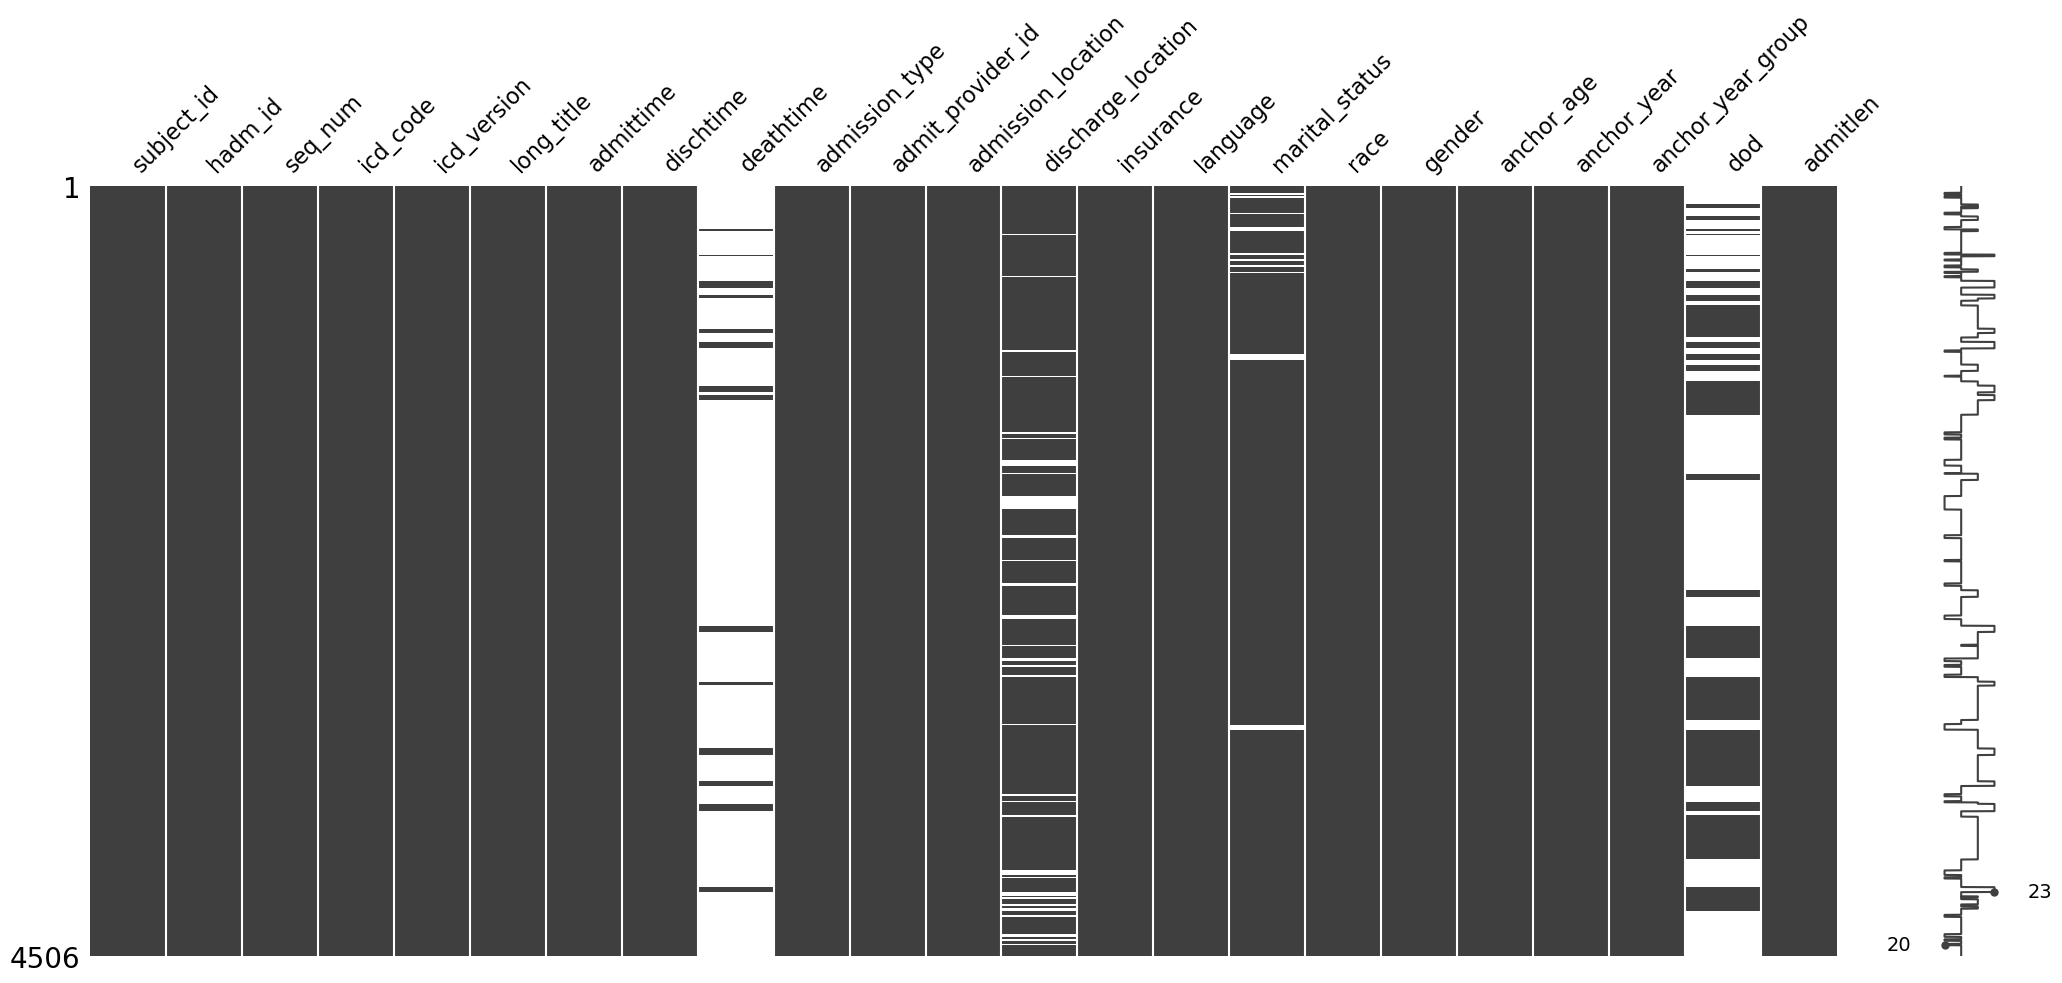

<Figure size 1500x900 with 0 Axes>

In [39]:
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

### I create some functions to visualize the variables with simple or stacked bar graphs

In [40]:
def vcgraph(df, var):
    # Calculate value counts
    counts = df[var].value_counts()
    # Plot value counts
    counts.plot(kind='bar', color='skyblue')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(str('Value Counts of '+var))
    plt.show()

def get_random_rgb_color():
    """Generates a random RGB color tuple."""
    r = random.randint(0, 255)/255.0
    g = random.randint(0, 255)/255.0
    b = random.randint(0, 255)/255.0
    return (r, g, b)

def vcgraph3(df, var1, var2, var3):
    df_pivot = pd.pivot_table(
        df, values=var1, index=var2, columns=var3, aggfunc="count"
    )
    
    library = df_pivot.columns.tolist()
    x = np.arange(len(library))
    
    u = df_pivot.index.to_list()
    v = {}
    colors = {}

    for a in u:
        v[a] = np.array(df_pivot.loc[a].tolist())
        colors[a] = get_random_rgb_color()

    bottom = np.zeros(len(library))
    for a in u:
        plt.bar(x, v[a], bottom=bottom, label=a, color=colors[a])
        bottom += v[a]

    plt.xticks(x, library,rotation=90)
    plt.xlabel(var3)
    plt.ylabel("count of " + str(var1))
    plt.title("R")
    plt.legend()
    plt.show()

### The graph below shows the importance to know your data: a count by row it is not very informative as several diagnostics are associated with the same hospitalization so there is multiple counting here.

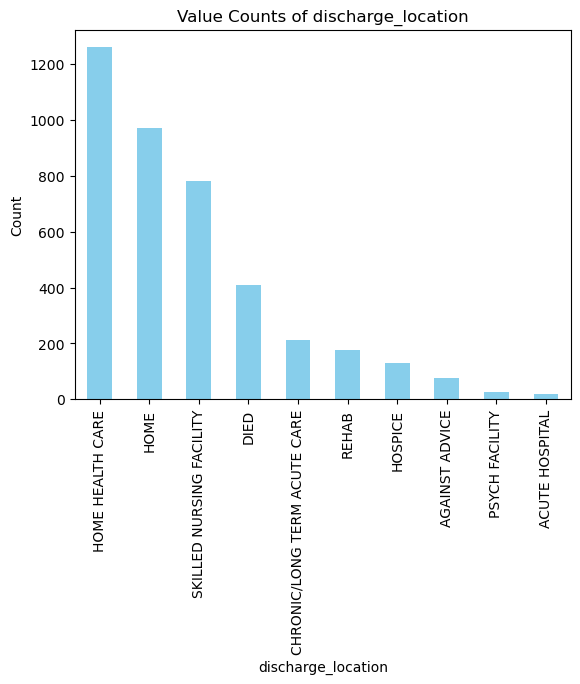

In [41]:
vcgraph(df, 'discharge_location')

### The graphs below reflect more the information we want by only looking at admission ids and dropping icd duplicates.

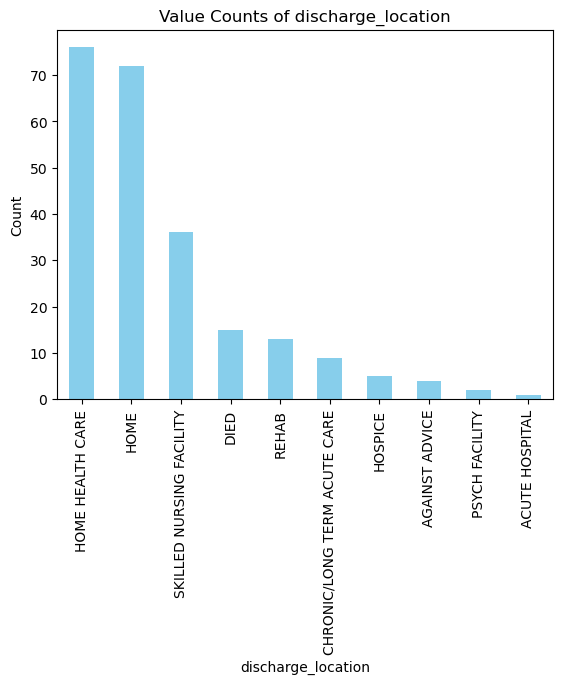

In [42]:
vcgraph(df[['subject_id', 'hadm_id','discharge_location']].drop_duplicates(), 'discharge_location')

### I can check the distribution of hospitalization length per admission.

array([[<Axes: title={'center': 'admitlen'}>]], dtype=object)

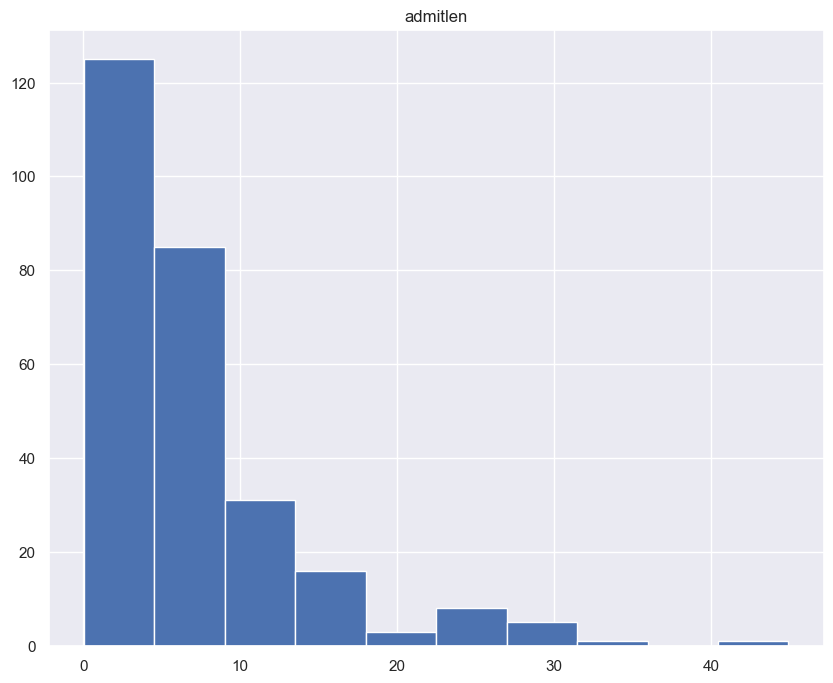

In [105]:
df[['subject_id', 'hadm_id','admitlen']].drop_duplicates()[['admitlen']].hist()

### The count below is rather informative on which diagnostics are associated with more admissions, because icd codes are repeated for the same patients across admissions. We see the first rows are chronic metabolic issues (essential hypertension, hyperlipidemia).

In [43]:
print(df['long_title'].value_counts(dropna=False).head(15))

long_title
Unspecified essential hypertension                                                                            68
Hyperlipidemia, unspecified                                                                                   57
Acute kidney failure, unspecified                                                                             56
Other and unspecified hyperlipidemia                                                                          55
Hypothyroidism, unspecified                                                                                   47
Obesity, unspecified                                                                                          43
Anemia, unspecified                                                                                           41
Long term (current) use of insulin                                                                            37
Urinary tract infection, site not specified                                          

### The count below would give more insight to the population we treat, as we are only looking at the patients.

In [44]:
dfa=df[['subject_id', 'long_title']].drop_duplicates()
print(dfa['long_title'].value_counts(dropna=False).head(15))

long_title
Unspecified essential hypertension                                                                            41
Other and unspecified hyperlipidemia                                                                          34
Acute kidney failure, unspecified                                                                             25
Anemia, unspecified                                                                                           25
Urinary tract infection, site not specified                                                                   22
Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled    21
Hyperlipidemia, unspecified                                                                                   21
Personal history of tobacco use                                                                               20
Obesity, unspecified                                                                 

### We can look at the distribution of admission numbers per patient. It would be interesting to check over which time this data was collected to understand then better the time distribution of these admissions.

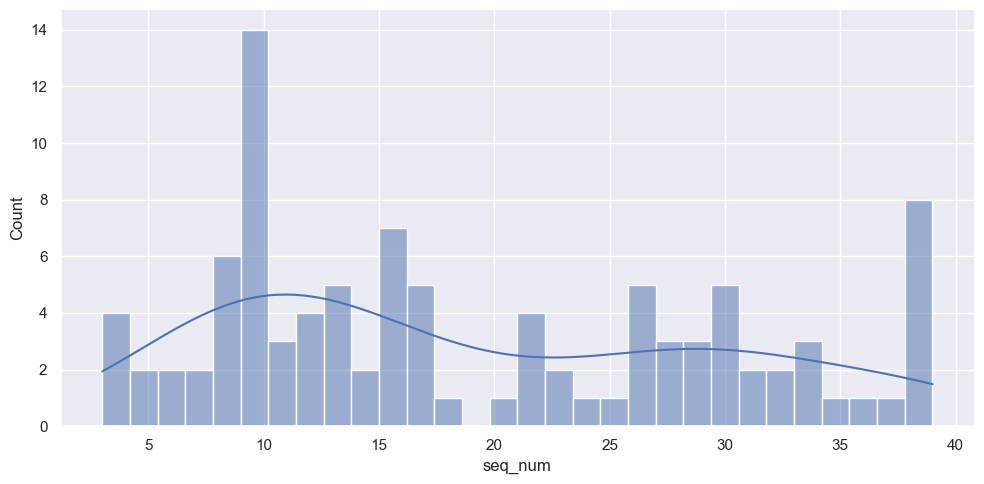

In [80]:
max_indices = df.groupby('subject_id')['seq_num'].idxmax()
result = df.loc[max_indices]
sns.set() # this sets the default seaborn style for all plots
sns.displot(result['seq_num'], bins=30, kde=True, aspect=2)

### But looking at the time column, we see there has been some intentional data shifting. The metadata explains it: To maintain patient privacy under HIPAA, all dates in MIMIC-IV are shifted randomly into a future period (between 2100 and 2200). Each patient has a unique date shift. Age has also been modified for the same reason.

In [96]:
df['admittime'] = pd.to_datetime(df['admittime']) 
agg_single = df['admittime'].agg(['min', 'max'])
print("Min and max for column A:")
print(agg_single)

Min and max for column A:
min   2110-04-11 15:08:00
max   2201-12-11 12:00:00
Name: admittime, dtype: datetime64[ns]


### With a real dataset, it would be interesting to check the time distribution as below. But in this case, it shows the result of deidentification under HIPAA

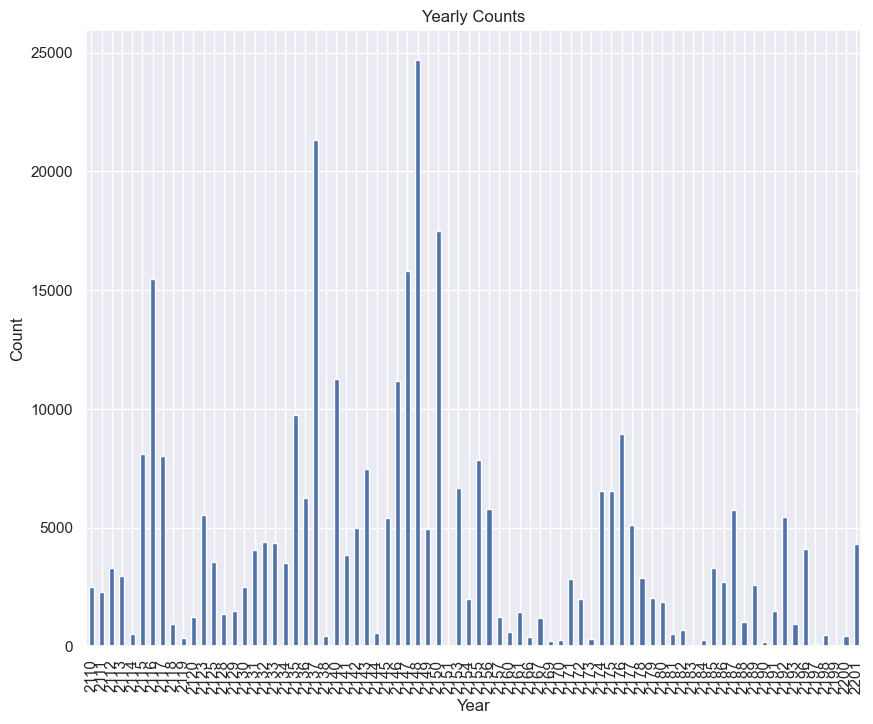

In [95]:
monthly_counts=df['admittime'].groupby([df.admittime.dt.year]).agg('count')
monthly_counts.plot(kind='bar', title='Yearly Counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()


### We can look at the average number of icd diagnosis by patient over their admissions

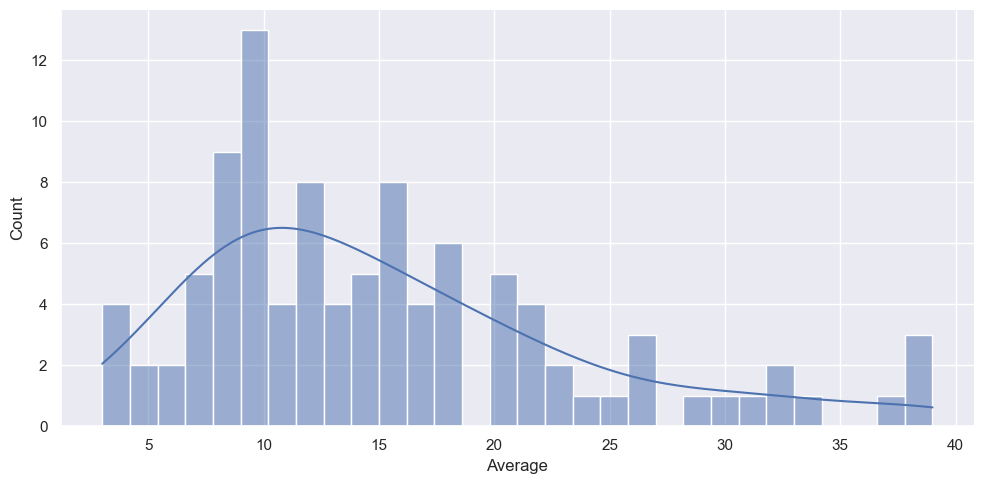

In [53]:
av=pd.pivot_table(
        df, values='long_title', index='subject_id', columns='hadm_id', aggfunc="count"
    )
av['Average'] = av.mean(axis=1)
# av['Average'].hist()
sns.set() # this sets the default seaborn style for all plots
sns.displot(av['Average'], bins=30, kde=True, aspect=2)

### or the distribution of the number of diagnostics icd codes per admission 

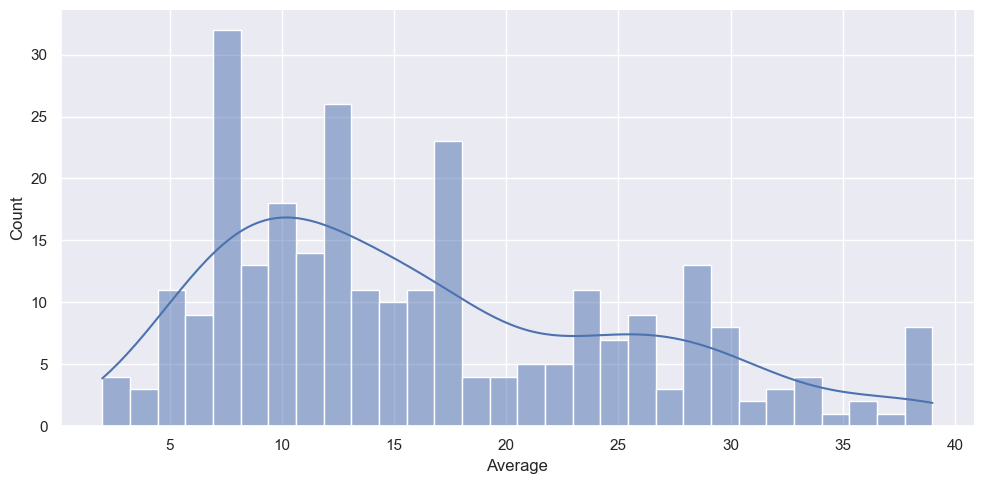

In [56]:
av=pd.pivot_table(
        df, values='long_title', index='hadm_id', columns='subject_id', aggfunc="count"
    )
av['Average'] = av.mean(axis=1)
# av['Average'].hist()
sns.set() # this sets the default seaborn style for all plots
sns.displot(av['Average'], bins=30, kde=True, aspect=2)

### We can also cross review some variables. For instance, here Medicare could be used as a proxy for age data, which is logic when we look at the two bars for lomg term care and death

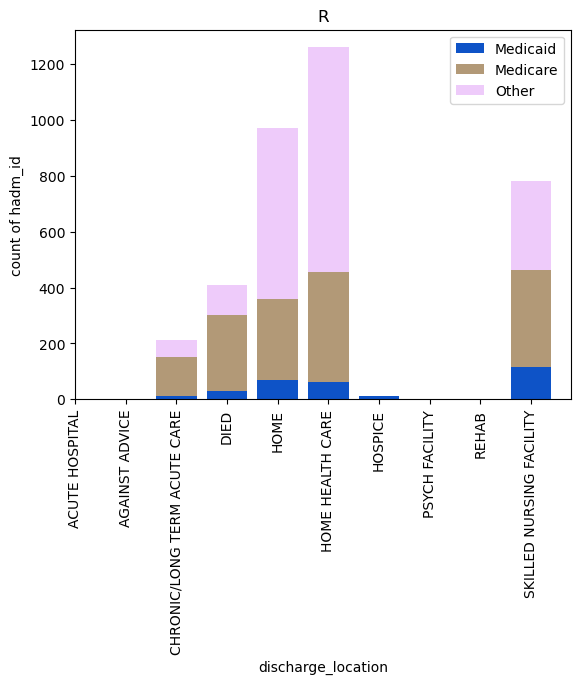

In [175]:
vcgraph3(df, 'hadm_id', 'insurance', 'discharge_location')

### From there we can look at an additional dataset on drug treatment. 

In [61]:
df4 = pd.read_csv('pharmacy.csv.gz', compression='gzip')
df4.head()

,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,...,basal_rate,one_hr_max,doses_per_24_hrs,duration,duration_interval,expiration_value,expiration_unit,expirationdate,dispensation,fill_quantity
0,10027602,28166872,24340150,NaN,2201-10-30 12:00:00,NaN,Midazolam,Miscellaneous Charges,Inactive (Due to a change order),2201-10-30 12:32:11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10027602,28166872,14435820,NaN,2201-10-30 12:00:00,NaN,Midazolam,Miscellaneous Charges,Inactive (Due to a change order),2201-10-30 12:54:34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10027602,28166872,40720238,NaN,2201-10-30 12:00:00,NaN,Fentanyl Citrate,Miscellaneous Charges,Inactive (Due to a change order),2201-10-30 12:32:11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10027602,28166872,27168639,NaN,2201-10-30 12:00:00,NaN,Fentanyl Citrate,Miscellaneous Charges,Inactive (Due to a change order),2201-10-30 12:54:34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10027602,28166872,62845687,NaN,2201-10-31 12:00:00,NaN,Lorazepam,Miscellaneous Charges,Inactive (Due to a change order),2201-10-31 12:02:42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


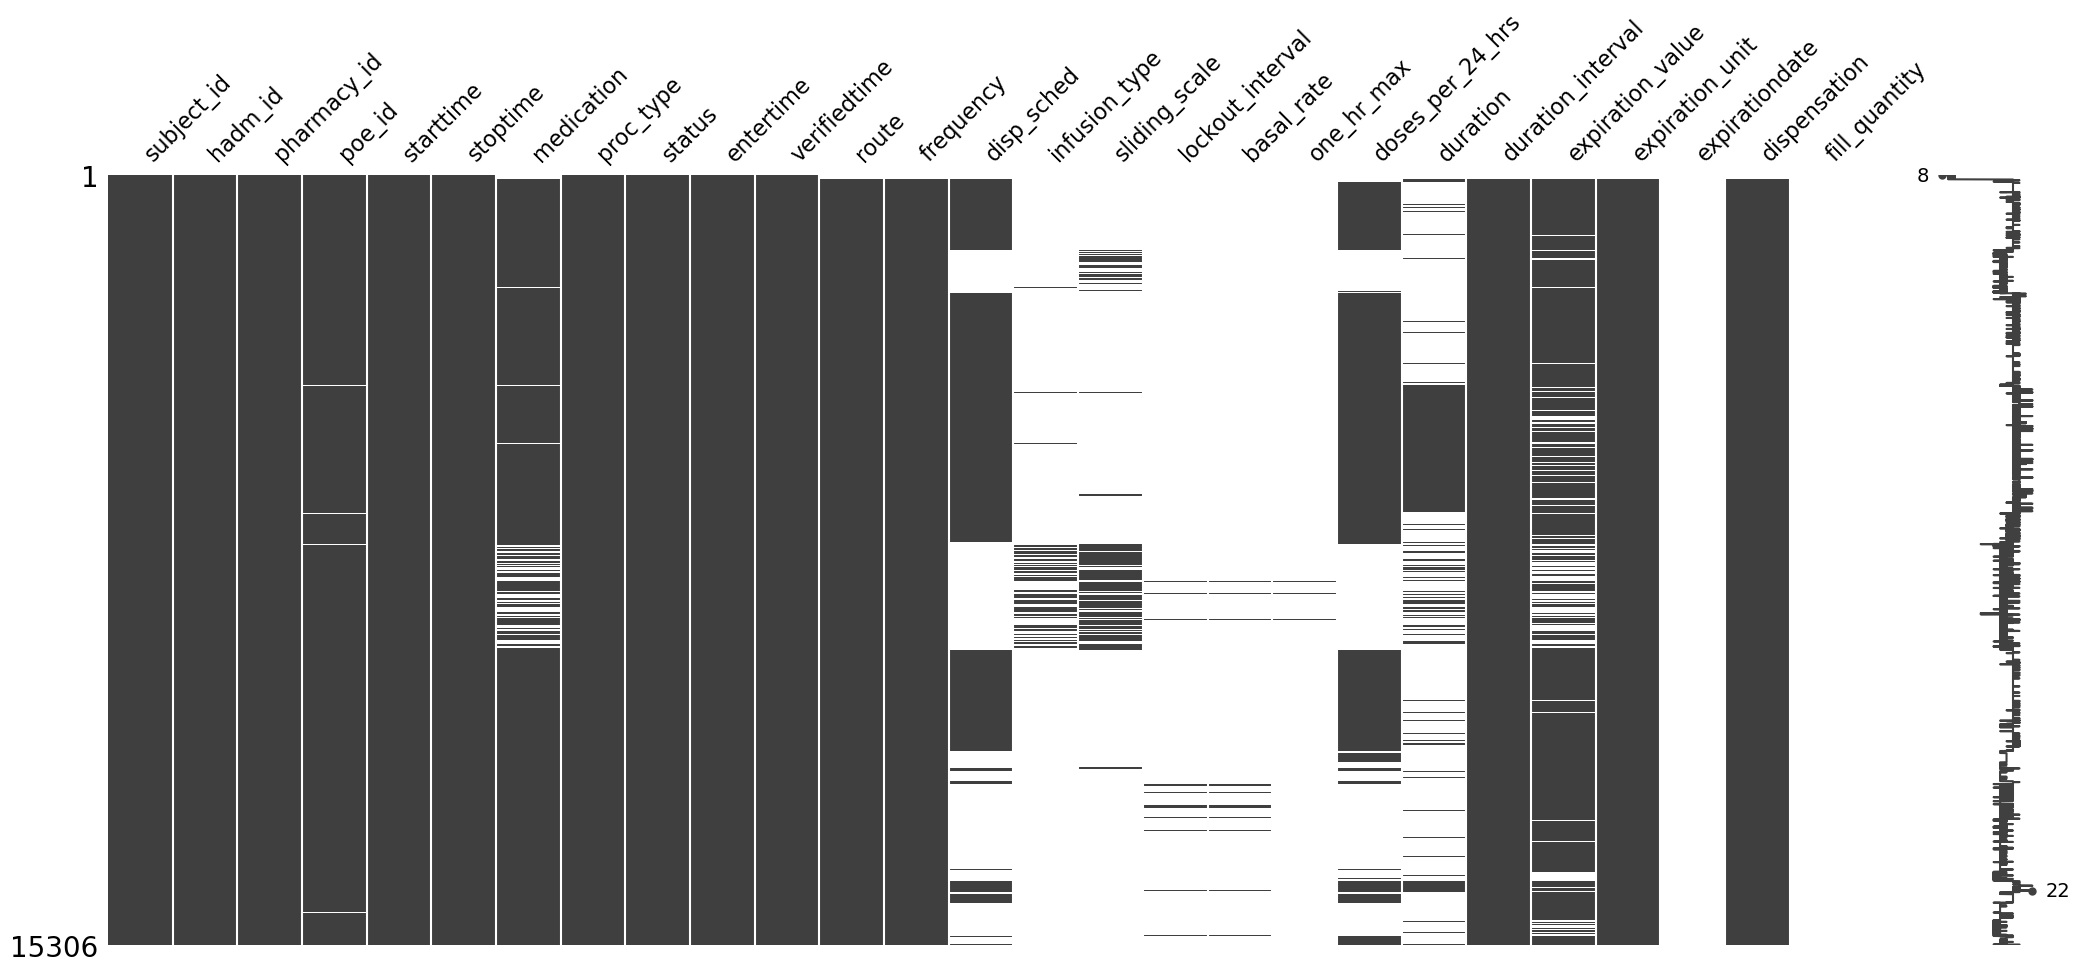

<Figure size 1500x900 with 0 Axes>

In [181]:
msno.matrix(df4)
plt.figure(figsize = (15,9))
plt.show()

### We seem to have an important amount of missing values in the field for medication. We can have a look at the status associated

In [62]:
df_with_nan_a= df4[df4['medication'].isna()]
df_with_nan_a.head(10)

,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,...,basal_rate,one_hr_max,doses_per_24_hrs,duration,duration_interval,expiration_value,expiration_unit,expirationdate,dispensation,fill_quantity
6,10020740,23831430,53634685,10020740-96,2150-03-12 14:00:00,NaN,NaN,TPN,Expired,2150-03-12 14:37:10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10002428,28662225,21001377,10002428-187,2156-04-17 08:00:00,2156-04-17 16:00:00,NaN,TPN,Discontinued,2156-04-17 09:27:13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10002428,28662225,51912443,10002428-219,2156-04-18 11:00:00,NaN,NaN,TPN,Expired,2156-04-18 10:52:02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10002428,28662225,29961424,10002428-235,2156-04-19 13:00:00,2156-04-20 08:00:00,NaN,TPN,Inactive (Due to a change order),2156-04-19 12:28:39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10002428,28662225,51234792,10002428-356,2156-04-20 12:00:00,NaN,NaN,TPN,Expired,2156-04-20 11:51:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,10002428,28662225,92502237,10002428-379,2156-04-21 10:00:00,NaN,NaN,TPN,Expired,2156-04-21 10:47:54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,10002428,28662225,84008739,10002428-428,2156-04-22 13:00:00,2156-04-23 10:00:00,NaN,TPN,Inactive (Due to a change order),2156-04-22 12:42:24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,10002428,28662225,35044693,10002428-454,2156-04-23 11:00:00,NaN,NaN,TPN,Expired,2156-04-23 13:01:16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,10005866,20364112,89257075,10005866-859,2149-10-02 12:00:00,NaN,NaN,TPN,Expired,2149-10-02 14:22:22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,10005866,20364112,18607249,10005866-893,2149-10-03 13:00:00,NaN,NaN,TPN,Expired,2149-10-03 13:13:52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


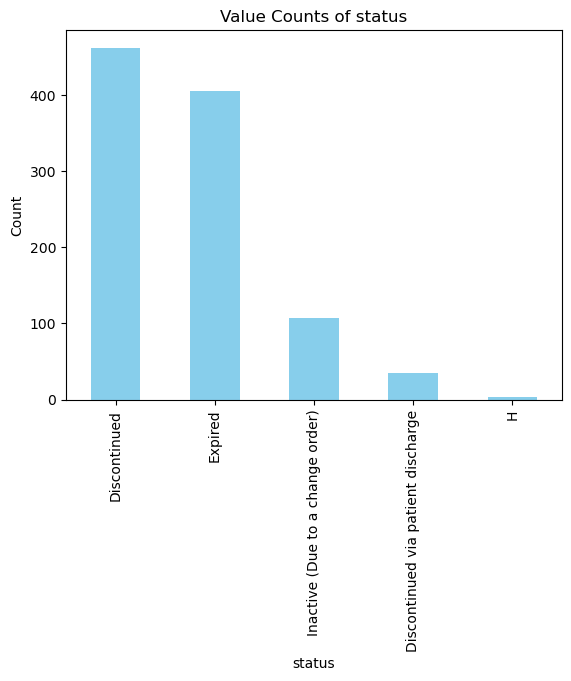

In [198]:
vcgraph(df_with_nan_a, 'status')

### We would need more deep dive in the metadata to understand better the reason behind these missing values. For now, let's look at the most prescribed medications by admission and by patient

In [63]:
dfb=df4[['subject_id', 'hadm_id', 'medication']].drop_duplicates()
print(dfb['medication'].value_counts(dropna=False).head(20))

medication
Sodium Chloride 0.9%  Flush    242
NaN                            199
Heparin                        178
Acetaminophen                  176
Docusate Sodium                155
Senna                          148
Dextrose 50%                   137
Insulin                        133
Glucagon                       130
Ondansetron                    116
Potassium Chloride             111
Furosemide                     103
Glucose Gel                    103
Aspirin                        100
Magnesium Sulfate               98
Bisacodyl                       89
Metoprolol Tartrate             88
Vancomycin                      81
HYDROmorphone (Dilaudid)        80
Heparin Flush (10 units/ml)     78
Name: count, dtype: int64


In [111]:
df3=df4[['subject_id', 'medication']].drop_duplicates()
print(df3['medication'].value_counts(dropna=False).head(20))

medication
Sodium Chloride 0.9%  Flush                                   98
NaN                                                           96
Heparin                                                       88
Acetaminophen                                                 82
Docusate Sodium                                               77
Senna                                                         76
Potassium Chloride                                            67
Dextrose 50%                                                  67
Ondansetron                                                   66
Insulin                                                       65
Bisacodyl                                                     65
Glucagon                                                      62
Magnesium Sulfate                                             58
Acetaminophen IV                                              56
Metoprolol Tartrate                                           54
Furosemide    

## The next notebook will use the same dataset to review some causal inference methods: logistic regression, glm, matching, propensity score matching.